In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import functions notebook and load data set here
import sys
sys.path.append("../")
from time_series_functions import *

In [3]:
df=pd.read_csv('../zillow_data.csv')

In [4]:
df=melt_data2(df)

In [5]:
df.set_index('time',inplace=True)

In [6]:
# Rename RegionName to be Zipcode
df=df.rename({'RegionName':'Zipcode'},axis='columns')

In [7]:
#drop no longer relevant columns
df.drop(['RegionID','SizeRank','City','CountyName'],axis=1,inplace=True)

In [8]:
Arizona_df= df[(df['State'] == 'AZ')]

In [9]:
Arizona_df

,Zipcode,State,Metro,value
time,,,,
1996-04-01,85032,AZ,Phoenix,95400.0
1996-04-01,85710,AZ,Tucson,94600.0
1996-04-01,85225,AZ,Phoenix,101200.0
1996-04-01,85308,AZ,Phoenix,124800.0
1996-04-01,85281,AZ,Phoenix,81200.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [10]:
Arizona_recent_yrs=Arizona_df['2009-01-01':'2018-04-01']

In [11]:
Arizona_recent_yrs

,Zipcode,State,Metro,value
time,,,,
2009-01-01,85032,AZ,Phoenix,190200.0
2009-01-01,85710,AZ,Tucson,171100.0
2009-01-01,85225,AZ,Phoenix,179900.0
2009-01-01,85308,AZ,Phoenix,212000.0
2009-01-01,85281,AZ,Phoenix,181300.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [12]:
Phoenix_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Phoenix')]

In [13]:
Phoenix_data
Phoenix_data=Phoenix_data.drop(['State','Metro'],axis=1)

In [14]:
top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
(Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                             (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]

In [15]:
def get_zip(zipcode):
    top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
    (Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                            (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]
    zip_zipcode=top_10_zips_phx[top_10_zips_phx['Zipcode']==zipcode]
    #zip_zipcode.drop(['index'],axis=1,inplace=True)
    zip_zipcode.reset_index(inplace=True)
    
    # shift by one period (month)
    resampled_shift_1 = zip_zipcode[['value']].shift(1)
    resampled_shift_1.bfill(inplace=True)

#reset the indexes to perform calculation of growth
    top_10_zips_phx = zip_zipcode.reset_index()
    resampled_shift_1 = resampled_shift_1.reset_index()

#Growth Calculation
    zip_zipcode['growth'] = (zip_zipcode['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])
    zip_zipcode['growth']= abs(zip_zipcode['growth'])
#set the index back to zipcode and time multi-index
    zip_zipcode.set_index(['time'],inplace=True)
    
    zip_zipcode.drop('Zipcode',axis=1,inplace=True)
    data= top_10_zips_phx
    print(f'The stationarity check for zipcode {zipcode} before adjustments:{stationarity_check(zip_zipcode.growth)}')
    
    #Original Plot
    fig, ax = plt.subplots()
    ax.plot(zip_zipcode.growth)
    ax.set_title(f"Original Zipcode Plot for {zipcode}");
    
    #log values and dropna
    log_zipcode= abs(np.log(zip_zipcode.growth))
    log_zipcode.dropna(inplace=True)
    
    # get roll mean and subtract
    roll_mean = log_zipcode.rolling(window=7,center=False).mean()
    data_minus_roll_mean = log_zipcode-roll_mean
    
    #Drop missing values
    data_minus_roll_mean.dropna(inplace=True)
    return data_minus_roll_mean
    #Plot the data minus roll mean
    #data_minus_roll_mean.plot(figsize=(10,6));
    fig, ax = plt.subplots()
    ax.plot(data_minus_roll_mean)
    ax.set_title(f"Final Zipcode Plot for {zipcode}");

    print(f'The stationarity check for zipcode {zipcode}, after adjustments:{stationarity_check(data_minus_roll_mean)}')
    


Results of Dickey-Fuller Test: 

Test Statistic                  -3.114566
p-value                          0.025494
#Lags Used                       2.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64
The stationarity check for zipcode 85054 before adjustments:None


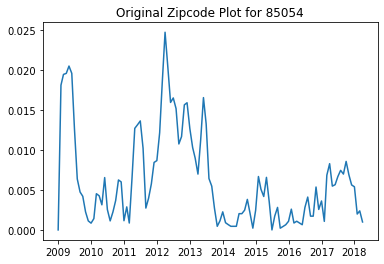

In [16]:
minus_roll_mean=get_zip(85054)

In [17]:
minus_roll_mean=minus_roll_mean.diff()

In [18]:
stationarity_check(minus_roll_mean)


Results of Dickey-Fuller Test: 

Test Statistic                -7.320054e+00
p-value                        1.200747e-10
#Lags Used                     4.000000e+00
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


In [19]:
# find the index which allows us to split off 20% of the data
cutoff = round(minus_roll_mean.shape[0]*0.8)
cutoff

78

In [20]:
# Define train and test sets according to the index found above
train = minus_roll_mean[:cutoff]

test = minus_roll_mean[cutoff:]

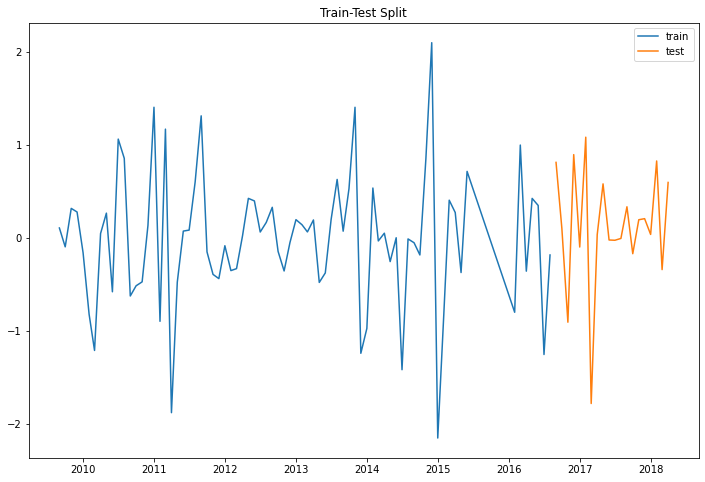

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [22]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13 14 15 16 17 18 19 20 21 22 23 24 25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] [26 27 28 29 30 31 32 33 34 35 36 37 38]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38] [39 40 41 42 43 44 45 46 47 48 49 50 51]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51] [52 53 54 55 56 57 58 59 60 61 62 63 64]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] [65 66 67 68 69 70 71 72 73 74 75 76 77]


In [23]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
baseline = train.shift(1)
baseline.dropna(inplace=True)

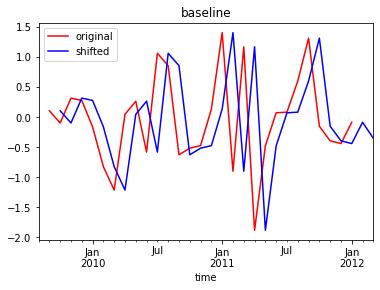

In [24]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [25]:
np.sqrt(mean_squared_error(train[2:], baseline.dropna()))

1.082103528538591

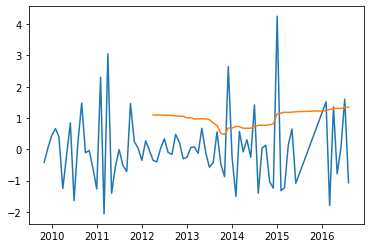

In [26]:
fig, ax = plt.subplots()
residuals = baseline[1:] - train[2:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

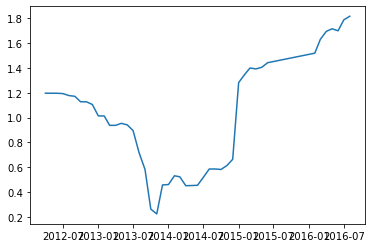

In [27]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

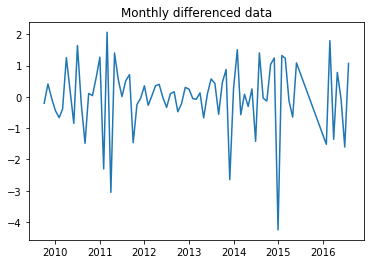

In [28]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

In [29]:
p_val = adfuller(train.diff()[2:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 6.837742145539868e-05,
 so we can safely assume that the differenced data is stationary.


In [30]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

time
2009-08-01    0.000000
2009-09-01    0.000000
2009-10-01    0.104464
2009-11-01   -0.000487
2009-12-01    0.115610
                ...   
2016-04-01    0.128248
2016-05-01    0.295036
2016-06-01    0.044868
2016-07-01    0.383637
2016-08-01   -0.482619
Name: predicted_mean, Length: 78, dtype: float64

In [31]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   78
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -111.563
Date:                Wed, 05 Jan 2022   AIC                            227.127
Time:                        11:23:34   BIC                            231.814
Sample:                             0   HQIC                           229.002
                                 - 78                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4828      0.103     -4.698      0.000      -0.684      -0.281
sigma2         0.8945      0.118      7.591      0.000       0.664       1.125
===================================================================================
Ljung-Box (L1) (Q):                   2.69   Jarque-Bera (JB):                21.72
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -0.86
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   78
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -121.663
Date:                Wed, 05 Jan 2022   AIC                            245.326
Time:                        11:23:35   BIC                            247.670
Sample:                             0   HQIC                           246.263
                                 - 78                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.1709      0.124      9.407      0.000       0.927       1.415
===================================================================================
Ljung-Box (L1) (Q):                  18.65   Jarque-Bera (JB):                41.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -1.17
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 245.32588951814384
AR(1, 1, 0) AIC: 227.12659631782464


In [34]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train[2:], y_hat_ar1[2:]))

0.945862201701356

In [35]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train[2:], y_hat_rw[2:]))

1.0821035285386111

In [36]:
train.index

DatetimeIndex(['2009-08-01', '2009-09-01', '2009-10-01', '2009-11-01',
               '2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
               '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01', '2010-10-01', '2010-11-01',
               '2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
               '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
      

In [37]:
train_with_ind = train.reset_index()

In [38]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.288542896280655
1.1328333946461988
0.5033496944095115
1.4500205874253762
2.096274025069542


In [39]:
ar_1.arparams

array([-0.48276653])

In [40]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1, 1), train[2:].diff().dropna())
print(lr.coef_)

[-0.48910974]


In [41]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

time
2009-08-01    0.000000
2009-09-01    0.000000
2009-10-01    0.104464
2009-11-01   -0.000903
2009-12-01    0.117920
                ...   
2016-04-01    0.371982
2016-05-01   -0.130765
2016-06-01    0.408132
2016-07-01    0.108174
2016-08-01   -0.173575
Name: predicted_mean, Length: 78, dtype: float64

In [42]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

245.32588951814384
227.12659631782464
218.06867391631366


In [43]:
y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train[2:], y_hat_ar1[2:]))

0.8779630640497128

In [44]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.0556109891671215
1.007311573719628
0.4941748175280722
1.319350668721389
1.7532007043125342


### Moving Avg

In [45]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

time
2009-08-01   -0.024141
2009-09-01   -0.024141
2009-10-01   -0.048807
2009-11-01   -0.014257
2009-12-01   -0.089878
                ...   
2016-04-01   -0.202221
2016-05-01    0.007352
2016-06-01   -0.107008
2016-07-01   -0.114679
2016-08-01    0.203652
Name: predicted_mean, Length: 78, dtype: float64

In [46]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   78
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -83.056
Date:                Wed, 05 Jan 2022   AIC                            172.112
Time:                        11:23:36   BIC                            179.182
Sample:                             0   HQIC                           174.942
                                 - 78                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0241      0.071     -0.341      0.733      -0.163       0.114
ma.L1         -0.1994      0.091     -2.197      0.028      -0.377      -0.022
sigma2         0.5060      0.068      7.447      0.000       0.373       0.639
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.71   Prob(JB):                         0.15
Heteroskedasticity (H):               1.17   Skew:                             0.22
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

245.32588951814384
227.12659631782464
218.06867391631366
190.63052242179145


In [48]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train[2:], y_hat_ar1[2:]))

0.7394532351016148

In [49]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.1498667310970485
0.292186763054844
0.5082459715757096
0.881285411067162
0.8765236871364974


In [50]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

time
2009-08-01    0.000000
2009-09-01    0.000000
2009-10-01    0.104464
2009-11-01    0.017303
2009-12-01    0.066788
                ...   
2016-04-01   -0.165998
2016-05-01    0.015513
2016-06-01   -0.079953
2016-07-01   -0.078462
2016-08-01    0.175755
Name: predicted_mean, Length: 78, dtype: float64

In [51]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

245.32588951814384
227.12659631782464
218.06867391631366
190.63052242179145
191.3463602566909


In [52]:
y_hat_ar1 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train[2:], y_hat_ar1[2:]))

0.7324561494060688

In [53]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.9081791161862023
0.28967752509001404
0.5084493639966873
0.8851047167885007
0.8977341831755906


### ARMA

In [54]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [55]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

245.32588951814384
227.12659631782464
218.06867391631366
190.63052242179145
191.3463602566909
195.7372134235893


In [56]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data[2:], y_hat[2:]))

In [57]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

1.0821035285386111
0.945862201701356
0.8779630640497128
0.7394532351016148
0.7324561494060688
0.7347046644385952


In [58]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.9079606359305493
0.2432266699729728
0.5150613973928301
0.9045612905323036
0.8897846881146598


In [59]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [60]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [61]:
sari_mod =SARIMAX(train,
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [64]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.258694711353221
1.3818082061747974
0.5687449593301721
1.5926911028117372
1.5389874712401435


In [65]:
sari_mod = SARIMAX(minus_roll_mean,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [66]:
forecast = sari_mod.forecast(steps=52)

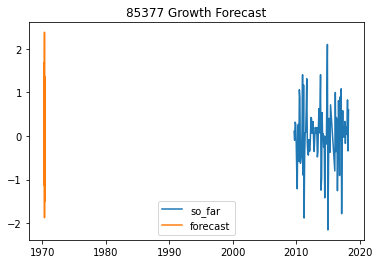

In [67]:
fig, ax = plt.subplots()
ax.plot(minus_roll_mean, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('85377 Growth Forecast')

plt.legend();